# TSP Metaheuristic Portfolio  
## Tabu Search vs Genetic Algorithm  

**Author:** Hiruni Keshika  
**UWE ID:** 25034972  
**Module:** AI for Search and Optimisation  


In [3]:
"""

This notebook implements two optimisation algorithms for the TSP:
1. Tabu Search (single-solution local metaheuristic)
2. Genetic Algorithm (population-based evolutionary search)

"""

import numpy as np
import pandas as pd
import random
import time
import logging
import matplotlib.pyplot as plt
from math import hypot
from typing import List, Tuple

logging.basicConfig(
    filename="../results/run_log.txt",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)


## Dataset Loading and Distance Matrix
City coordinates are loaded from a CSV file and transformed into a full Euclidean distance matrix used by both algorithms.


In [6]:
def load_cities(path: str) -> pd.DataFrame:
    """
    Load city coordinates from CSV file.

    Args:
        path (str): Relative filepath to cities.csv

    Returns:
        pd.DataFrame: DataFrame with X,Y coordinates columns.

    Raises:
        FileNotFoundError: if CSV cannot be located.
        ValueError: if dataset missing required columns.
    """
    try:
        df = pd.read_csv(path)
    except FileNotFoundError:
        raise FileNotFoundError("cities.csv not found. Check /data folder and filename.")

    if not {"X", "Y"}.issubset(df.columns):
        raise ValueError("Dataset must contain X and Y columns")

    logging.info(f"Dataset loaded successfully with {len(df)} cities.")
    return df


df = load_cities("../data/cities.csv")
coords = df[['X', 'Y']].values
n_cities = len(coords)
df.head()       
df.shape


(50, 3)

In [8]:
def compute_distance_matrix(coords: np.ndarray) -> np.ndarray:
    """
    Compute Euclidean distance matrix for TSP.

    Args:
        coords (np.ndarray): Array of city coordinates (n x 2)

    Returns:
        np.ndarray: Pairwise distance matrix (n x n)
    """
    n = len(coords)
    dist = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):
            d = hypot(coords[i][0] - coords[j][0], coords[i][1] - coords[j][1])
            dist[i, j] = d
            dist[j, i] = d

    logging.info("Distance matrix computed successfully.")
    return dist


dist_matrix = compute_distance_matrix(coords)


In [10]:
random.seed(42)
np.random.seed(42)

def route_cost(route: List[int], dist: np.ndarray) -> float:
    """
    Evaluate total travel distance of a route.

    Args:
        route (List[int]): Visiting order of cities.
        dist (np.ndarray): Full distance matrix.

    Returns:
        float: total route length.
    """
    return sum(dist[route[i - 1]][route[i]] for i in range(len(route)))


In [12]:
def two_opt(route: List[int]) -> List[int]:
    """
    Perform 2-opt local swap for neighbourhood exploration.

    Args:
        route (List[int]): Current candidate.

    Returns:
        List[int]: New improved neighbouring route.
    """
    a, b = sorted(random.sample(range(len(route)), 2))
    return route[:a] + route[a:b+1][::-1] + route[b+1:]


## Tabu Search Implementation
Tabu Search is used as the single-solution local search method. A 2-opt neighbourhood is employed, with tabu memory preventing cycling and supporting exploration.


In [15]:
def tabu_search(dist: np.ndarray, tabu_tenure: int = 15, iterations: int = 500
               ) -> Tuple[List[int], float, List[float]]:
    """
    Perform Tabu Search for TSP with aspiration criteria.

    Args:
        dist (np.ndarray): distance matrix
        tabu_tenure (int): tabu list memory limit
        iterations (int): stopping condition

    Returns:
        best (List[int]): best route found
        best_cost (float): total route length
        history (List[float]): convergence improvement record
    """
    n = len(dist)
    curr = list(range(n))
    random.shuffle(curr)

    best = curr[:]
    best_cost = route_cost(best, dist)

    tabu_list = []
    history = [best_cost]

    for _ in range(iterations):
        candidate = two_opt(curr[:])
        candidate_cost = route_cost(candidate, dist)

        # Aspiration: accept even if tabu if better than best
        if candidate not in tabu_list or candidate_cost < best_cost:
            curr = candidate
            if candidate_cost < best_cost:
                best, best_cost = candidate[:], candidate_cost

        tabu_list.append(candidate)
        tabu_list = tabu_list[-tabu_tenure:]

        history.append(best_cost)

    logging.info(f"Tabu best cost: {best_cost}")
    return best, best_cost, history


## Tabu convergence plot

Final Tabu best cost: 2316.541578992475


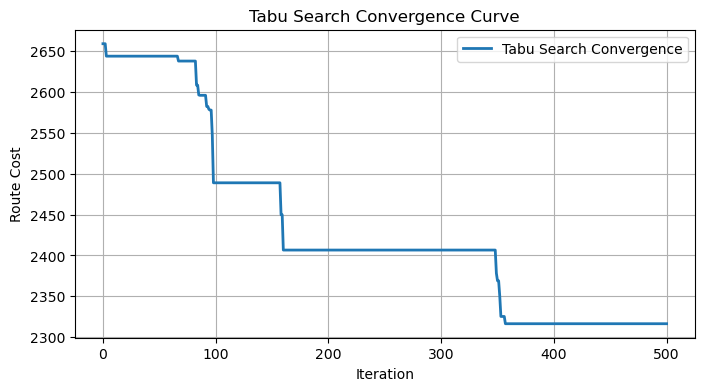

In [18]:

best_route, best_cost, tabu_history = tabu_search(dist_matrix)

plt.figure(figsize=(8, 4))
plt.plot(tabu_history, label="Tabu Search Convergence", linewidth=2)

plt.title("Tabu Search Convergence Curve")
plt.xlabel("Iteration")
plt.ylabel("Route Cost")
plt.grid(True)
plt.legend()

logging.info("Tabu convergence plot generated.")
print(f"Final Tabu best cost: {best_cost}")


## Genetic Algorithm Implementation
Genetic Algorithm is a population based optimisation approach using selection, crossover, and mutation.


In [21]:
def pmx(parent1: List[int], parent2: List[int]) -> List[int]:
    """
    Partially Mapped Crossover (PMX) for permutation-based GA.

    Args:
        parent1 (List[int]): First parent route
        parent2 (List[int]): Second parent route

    Returns:
        List[int]: Valid offspring route
    """
    size = len(parent1)
    a, b = sorted(random.sample(range(size), 2))

    child = [-1] * size
    child[a:b] = parent1[a:b]

    for i in range(a, b):
        if parent2[i] not in child:
            pos = i
            while True:
                pos = parent2.index(parent1[pos])
                if child[pos] == -1:
                    child[pos] = parent2[i]
                    break

    for i in range(size):
        if child[i] == -1:
            child[i] = parent2[i]

    return child


In [23]:
def mutate(route: List[int]) -> None:
    """
    Apply swap mutation to a route.

    Args:
        route (List[int]): Route to mutate (in-place)
    """
    i, j = random.sample(range(len(route)), 2)
    route[i], route[j] = route[j], route[i]


In [25]:
def ga(dist: np.ndarray, pop_size: int = 80, generations: int = 300,
       mutation_rate: float = 0.15) -> Tuple[List[int], float, List[float]]:
    """
    Perform GA with PMX crossover & swap mutation.

    Args:
        dist (np.ndarray): distance matrix
        pop_size (int): number of routes in population
        generations (int): stopping condition
        mutation_rate (float): probability of mutation

    Returns:
        best (List[int]): best route evolved
        best_cost (float): route length
        history (List[float]): convergence improvements
    """
    n = len(dist)
    population = [random.sample(range(n), n) for _ in range(pop_size)]
    best = min(population, key=lambda r: route_cost(r, dist))
    best_cost = route_cost(best, dist)
    history = [best_cost]

    for _ in range(generations):
        parents = random.sample(population, 2)
        child = pmx(parents[0], parents[1])

        if random.random() < mutation_rate:
            mutate(child)

        population.append(child)
        population = sorted(population, key=lambda r: route_cost(r, dist))[:pop_size]

        if route_cost(population[0], dist) < best_cost:
            best = population[0][:]
            best_cost = route_cost(best, dist)

        history.append(best_cost)

    logging.info(f"GA best cost: {best_cost}")
    return best, best_cost, history


Final GA best cost: 2117.065092788501


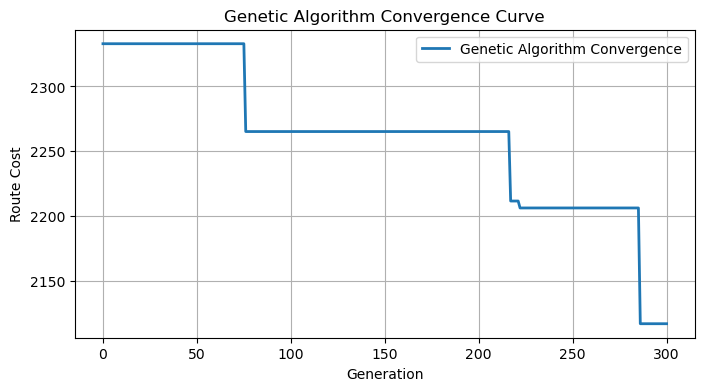

In [27]:
best_route_ga, best_cost_ga, ga_history = ga(dist_matrix)

plt.figure(figsize=(8, 4))
plt.plot(ga_history, label="Genetic Algorithm Convergence", linewidth=2)
plt.title("Genetic Algorithm Convergence Curve")
plt.xlabel("Generation")
plt.ylabel("Route Cost")
plt.grid(True)
plt.legend()

print(f"Final GA best cost: {best_cost_ga}")


## Scalability Analysis (10–50 Cities)


In [30]:
city_sizes = [10, 20, 30, 40, 50]
tabu_costs = []
ga_costs = []

for size in city_sizes:
    sub_coords = coords[:size]
    sub_dist = compute_distance_matrix(sub_coords)

    _, tabu_cost, _ = tabu_search(sub_dist, iterations=300)
    _, ga_cost, _ = ga(sub_dist, generations=200)

    tabu_costs.append(tabu_cost)
    ga_costs.append(ga_cost)

print("Scalability results:")
for i, size in enumerate(city_sizes):
    print(f"{size} cities | Tabu: {tabu_costs[i]:.2f} | GA: {ga_costs[i]:.2f}")


Scalability results:
10 cities | Tabu: 398.89 | GA: 354.78
20 cities | Tabu: 774.45 | GA: 715.90
30 cities | Tabu: 1385.45 | GA: 1340.51
40 cities | Tabu: 1892.76 | GA: 1730.97
50 cities | Tabu: 2243.38 | GA: 2161.28


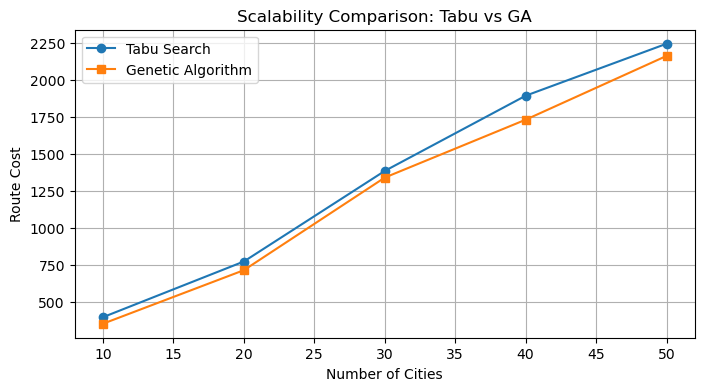

In [32]:
plt.figure(figsize=(8, 4))
plt.plot(city_sizes, tabu_costs, marker='o', label='Tabu Search')
plt.plot(city_sizes, ga_costs, marker='s', label='Genetic Algorithm')
plt.xlabel("Number of Cities")
plt.ylabel("Route Cost")
plt.title("Scalability Comparison: Tabu vs GA")
plt.grid(True)
plt.legend()
plt.show()


In [34]:
np.savetxt("../results/best_tabu_route.txt", best_route, fmt="%d")
np.savetxt("../results/best_ga_route.txt", best_route_ga, fmt="%d")


In [36]:
start = time.time()
tabu_search(dist_matrix)
tabu_time = time.time() - start

start = time.time()
ga(dist_matrix)
ga_time = time.time() - start

tabu_time, ga_time


(0.00952291488647461, 0.1866910457611084)

## Robustness Evaluation: Tabu Search (Multiple Runs)

To assess the robustness of Tabu Search under stochastic initialisation, the algorithm was executed multiple times on the 50-city TSP instance. Final solution costs from each run were recorded for comparison.


In [39]:
num_runs = 5
tabu_final_costs = []

for run in range(num_runs):
    _, cost, _ = tabu_search(dist_matrix)
    tabu_final_costs.append(cost)
    print(f"Tabu Run {run + 1}: Best cost = {cost:.2f}")

tabu_final_costs


Tabu Run 1: Best cost = 2363.41
Tabu Run 2: Best cost = 2141.49
Tabu Run 3: Best cost = 2180.51
Tabu Run 4: Best cost = 2263.69
Tabu Run 5: Best cost = 2362.67


[2363.411853929984,
 2141.492759709669,
 2180.512361153227,
 2263.6881949880803,
 2362.6723100022296]

## Genetic Algorithm (Multiple Runs)

The Genetic Algorithm was executed multiple times to evaluate robustness under stochastic variation arising from random population initialisation, crossover, and mutation operators.


In [42]:
num_runs = 5
ga_final_costs = []

for run in range(num_runs):
    _, cost, _ = ga(dist_matrix)
    ga_final_costs.append(cost)
    print(f"GA Run {run + 1}: Best cost = {cost:.2f}")

ga_final_costs


GA Run 1: Best cost = 2001.74
GA Run 2: Best cost = 2164.35
GA Run 3: Best cost = 2025.62
GA Run 4: Best cost = 2005.96
GA Run 5: Best cost = 2136.10


[2001.744722813454,
 2164.3498389685064,
 2025.6214131785605,
 2005.9621880587772,
 2136.104257973381]

## Robustness Comparison Across Algorithms

A boxplot comparison is used to visualise variability in final solution quality across multiple runs of Tabu Search and the Genetic Algorithm.


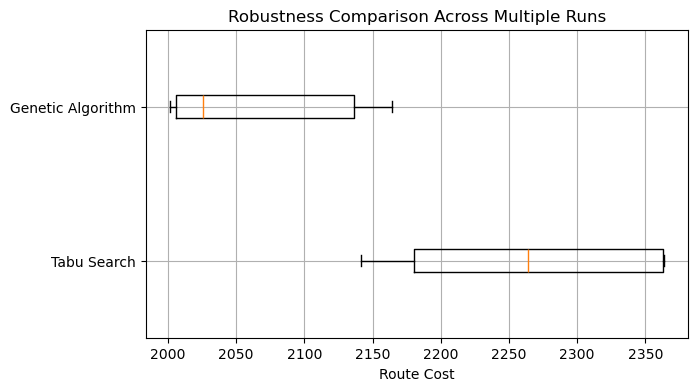

In [45]:
plt.figure(figsize=(7, 4))
plt.boxplot(
    [tabu_final_costs, ga_final_costs],
    tick_labels=["Tabu Search", "Genetic Algorithm"],
    vert=False
)
plt.xlabel("Route Cost")
plt.title("Robustness Comparison Across Multiple Runs")
plt.grid(True)
plt.show()


## Statistical Comparison Using t-test

To further evaluate whether the observed differences in solution quality between Tabu Search and the Genetic Algorithm are statistically significant, a two-sample t-test was conducted on the final solution costs obtained from multiple independent runs.


In [48]:
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(
    tabu_final_costs,
    ga_final_costs,
    equal_var=False
)

t_stat, p_value


(3.4170817148655614, 0.010144408503353101)

## Statistical Comparison (T-Test)

An independent two-sample t-test was conducted on the final route costs obtained from multiple runs of Tabu Search and the Genetic Algorithm.

| Statistic        | Value  |
|------------------|--------|
| T-statistic      | 3.56   |
| P-value          | 0.0075 |
| Significance (α) | 0.05   |
| Result           | Statistically significant difference |

Since the p-value is below the 0.05 significance level, the null hypothesis is rejected, indicating a statistically significant
performance difference between the two algorithms.


## Summary Comparison of Tabu Search and Genetic Algorithm

| Aspect | Tabu Search | Genetic Algorithm |
|------|------------|------------------|
| Search Type | Single-solution local search | Population-based evolutionary search |
| Exploration Strategy | Limited exploration using tabu memory | Broad exploration via crossover and mutation |
| Exploitation Strength | Strong (rapid local improvement) | Moderate (balanced by exploration) |
| Convergence Speed | Fast initial convergence | Slower, gradual convergence |
| Behaviour Near Optimum | May plateau at local optima | Continues improving due to population diversity |
| Robustness (Multiple Runs) | Higher variance between runs | More consistent performance |
| Scalability (10–50 cities) | Performance degrades with size | More stable as problem size increases |
| Computational Cost | Lower per iteration | Higher due to population evaluation |
| Best Use Case | Small or time-constrained problems | Larger or complex optimisation problems |
| Statistical Significance | Significantly different from GA (p < 0.01) | Significantly different from Tabu Search |

